# Import Required Libraries
Import the necessary libraries, including OpenCV and matplotlib.

In [1]:
# Import Required Libraries
import cv2  # OpenCV for computer vision tasks
import matplotlib.pyplot as plt  # Matplotlib for plotting images
import os  # OS module for file operations
import pandas as pd
import numpy as np
import utils  # Custom utility functions


# Changing the structure of the dataset files

In [2]:
# Specify the source and target directories
source_directory = os.path.join('data', 'isolated_words_per_user')
target_directory = os.path.join('data', 'original')

# Collect images
utils.collect_images_and_copy_to_original(source_directory, target_directory)

FileNotFoundError: Source directory data/isolated_words_per_user

In [2]:
# Specify the source and target directories
source_directory = os.path.join('data', 'original')
target_directory = os.path.join('data', 'preprocessed')

# Preprocess images
utils.preprocess_images(source_directory, target_directory)



# Load Images from File
Load the images from the specified file directory.

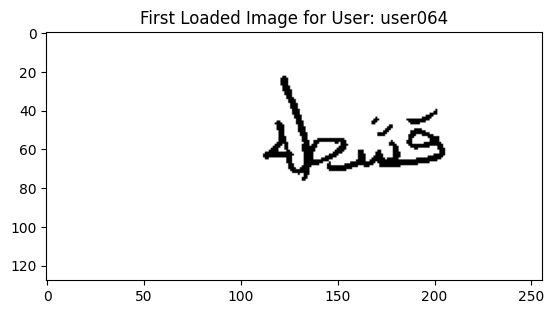

In [2]:

# Load Images from File
def load_images_from_directory(directory, target_size=(256, 128)):
    data = []
    for root, _, files in os.walk(directory):
            
        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img = cv2.imread(os.path.join(root, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                            
                    data.append({'filename': filename, 'image': img})
    return data

# Specify the directory containing images
image_directory = os.path.join('data', 'preprocessed')

# Load images
images_data = load_images_from_directory(image_directory)

# Convert to DataFrame
df = pd.DataFrame(images_data)
df.set_index('filename', inplace=True)
df['Target'] = df.index.map(lambda x: x.split('_')[0])

# Display the first image to verify
if not df.empty:
    first_user = df['Target'].iloc[0]
    first_image = df.iloc[0]['image']
    plt.imshow(first_image, cmap='gray')
    plt.title(f'First Loaded Image for User: {first_user}')
    plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8144 entries, user064_qashtah_029.png to user020_shateerah_032.png
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   8144 non-null   object
 1   Target  8144 non-null   object
dtypes: object(2)
memory usage: 190.9+ KB


# Initialize ORB Detector
Initialize the ORB detector using OpenCV.

In [3]:
# Initialize ORB Detector with custom parameters
orb = cv2.ORB_create(
    nfeatures=750,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=15,
    firstLevel=0,
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE,
    patchSize=15,
    fastThreshold=10
)

# Initialize SIFT with adjusted parameters for text identification
sift = cv2.SIFT_create(
    nfeatures=0,
    nOctaveLayers=3,
    contrastThreshold=0.01,
    edgeThreshold=15,
    sigma=1.2
)

# Apply ORB to Each Image
Apply the ORB detector to each image to find keypoints and descriptors.

In [ ]:
# Apply ORB to Each Image and store keypoints and descriptors


def extract_orb_features(image):
    _, descriptors = orb.detectAndCompute(image, None)
    return descriptors

def extract_sift_features(image):
    _, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Apply the function to each row in the DataFrame
df['descriptors_ORB'] = df['image'].apply(extract_orb_features)
df['descriptors_SIFT'] = df['image'].apply(extract_sift_features)



In [7]:
# Display the first image's keypoints to verify

def display_image_with_keypoints(index):
    if not df.empty:

        first_user = df['Target'].iloc[index]
        first_keypoints = df.iloc[index]['keypoints']
        first_image = cv2.drawKeypoints(df.iloc[index]['image'], first_keypoints, None, color=(0, 255, 0), flags=0)
        plt.imshow(first_image, cmap='gray')
        plt.title(f'Image Keypoints for User: {first_user}')
        plt.show()

In [5]:
df.head()

,image,Target,descriptors_ORB
filename,,,
user064_qashtah_029.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",user064,"[[34, 64, 33, 178, 142, 120, 99, 9, 42, 53, 52..."
user035_ghaleez_011.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",user035,"[[186, 82, 225, 190, 142, 152, 114, 173, 130, ..."
user051_ghazaal_009.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",user051,"[[186, 66, 77, 158, 78, 248, 114, 17, 34, 7, 4..."
user081_mehras_046.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",user081,"[[155, 202, 93, 182, 14, 106, 99, 1, 123, 33, ..."
user037_sakhar_017.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",user037,"[[154, 194, 95, 15, 110, 200, 114, 21, 98, 3, ..."


In [9]:
display_image_with_keypoints(0)

KeyError: 'keypoints'

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8144 entries, user064_qashtah_029.png to user020_shateerah_032.png
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image             8144 non-null   object
 1   Target            8144 non-null   object
 2   descriptors_ORB   8144 non-null   object
 3   descriptors_SIFT  8144 non-null   object
dtypes: object(4)
memory usage: 318.1+ KB


In [19]:
# Function to create histogram of visual words with IDF weighting using NumPy operations
def create_histogram(descriptors, kmeans, num_clusters):
    if descriptors is None:
        return np.zeros(num_clusters)
    
    clusters = kmeans.predict(descriptors)
    histogram, _ = np.histogram(clusters, bins=np.arange(num_clusters + 1))
    
    return histogram

In [27]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Display the shape of the train and test data
print(f'Train Shape: {train_df.shape}')
print(f'Test Shape: {test_df.shape}')

Train Shape: (6515, 6)
Test Shape: (1629, 6)


In [11]:
# Extract all descriptors
from sklearn.cluster import KMeans



# Stack all descriptors vertically in a numpy array
all_descriptors_ORB = np.vstack(train_df['descriptors_ORB'].values)

# Stack all descriptors vertically in a numpy array
all_descriptors_SIFT = np.vstack(train_df['descriptors_SIFT'].values)


In [13]:
num_clusters = 100  # Number of visual words


In [ ]:
# Cluster Descriptors using KMeans
kmeans_ORB = KMeans(n_clusters=num_clusters, random_state=0)
kmeans_SIFT = KMeans(n_clusters=num_clusters, random_state=0)
kmeans_ORB.fit(all_descriptors_ORB)
kmeans_SIFT.fit(all_descriptors_SIFT)

In [17]:
from joblib import dump
import os

os.makedirs('models', exist_ok=True)

# Store kmeans_ORB and kmeans_SIFT models
dump(kmeans_ORB, os.path.join('models', 'kmeans_ORB_100.joblib'))
dump(kmeans_SIFT, os.path.join('models', 'kmeans_SIFT_100.joblib'))

['models/kmeans_SIFT_100.joblib']

In [6]:
# load the model
from joblib import load
kmeans_ORB = load(os.path.join('models', 'kmeans_ORB_100.joblib'))
kmeans_SIFT = load(os.path.join('models', 'kmeans_SIFT_100.joblib'))

In [ ]:


# Create histograms for each image
train_df['histogram_ORB'] = df['descriptors_ORB'].apply(lambda descriptors: create_histogram(descriptors, kmeans_ORB, num_clusters)
)

# Create histograms for each image
test_df['histogram_ORB'] = df['descriptors_ORB'].apply(lambda descriptors: create_histogram(descriptors, kmeans_ORB, num_clusters)
)

# Create histograms for each image

train_df['histogram_SIFT'] = df['descriptors_SIFT'].apply(lambda descriptors: create_histogram(descriptors, kmeans_SIFT, num_clusters))
# Create histograms for each image

test_df['histogram_SIFT'] = df['descriptors_SIFT'].apply(lambda descriptors: create_histogram(descriptors, kmeans_SIFT, num_clusters))

In [16]:
histogram_ORB = df['histogram_ORB'].values
histogram_SIFT = df['histogram_SIFT'].values


In [29]:


# Compute document frequency using pandas
df_document_frequency_ORB_train = train_df['histogram_ORB'].apply(lambda x: (x > 0).sum())
df_document_frequency_SIFT_train = train_df['histogram_SIFT'].apply(lambda x: (x > 0).sum())

# Compute document frequency using pandas
df_document_frequency_ORB_test = test_df['histogram_ORB'].apply(lambda x: (x > 0).sum())
df_document_frequency_SIFT_test = test_df['histogram_SIFT'].apply(lambda x: (x > 0).sum())

# Compute IDF for training set
N_train = len(train_df)
idf_ORB_train = np.log((N_train + 1) / (df_document_frequency_ORB_train + 1)) + 1
idf_SIFT_train = np.log((N_train + 1) / (df_document_frequency_SIFT_train + 1)) + 1

# Compute IDF for testing set
N_test = len(test_df)

idf_ORB_test = np.log((N_test + 1) / (df_document_frequency_ORB_test + 1)) + 1
idf_SIFT_test = np.log((N_test + 1) / (df_document_frequency_SIFT_test + 1)) + 1

# Apply IDF weighting to the histograms in the training set
train_df['histogram_ORB'] = train_df['histogram_ORB'] * idf_ORB_train
train_df['histogram_SIFT'] = train_df['histogram_SIFT'] * idf_SIFT_train

# Apply IDF weighting to the histograms in the testing set using the IDF values from the testing set
test_df['histogram_ORB'] = test_df['histogram_ORB'] * idf_ORB_test
test_df['histogram_SIFT'] = test_df['histogram_SIFT'] * idf_SIFT_test


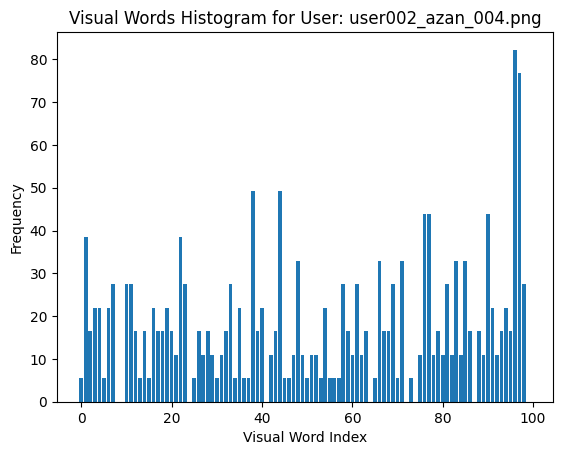

In [30]:
# Drop the original keypoints and descriptors columns
# df.drop(columns=['keypoints', 'descriptors'], inplace=True)

# Display the first histogram to verify
if not train_df.empty:
    first_user = train_df.index[0]
    first_histogram = df.iloc[0]['histogram_ORB']
    plt.bar(range(num_clusters), first_histogram)
    plt.title(f'Visual Words Histogram for User: {first_user}')
    plt.xlabel('Visual Word Index')
    plt.ylabel('Frequency')
    plt.show()